In [8]:
"PyTorch implementation of influence function calculation using stochastic estimation. "

'PyTorch implementation of influence function calculation using stochastic estimation. '

In [9]:
import torch 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np 
from sklearn.linear_model import LogisticRegression 
import random


In [ ]:
# load minst dataset
def load_mnist(batch_size=1400): 
    """Load minst dataset""" 
    # Define transform for normalizing and transforming. 
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1)) 
    ])

    full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    
    # Dataloader 
    train_loader = DataLoader(full, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test, batch_size=batch_size)
    return train_loader, test_loader, len(full) 

In [ ]:
# Define PyTorch model
# Uses a sklearn model as the KL experiment did. 
class Model(nn.Module): 
    def __init__(self, input_dim, num_classes, weight_decay=0.01):
        super().__init__()
        self.input_dim = input_dim # 28 * 28 = 784
        self.num_classes = num_classes # 10-classes
        self.weight_decay = weight_decay # 1e-2
        
        n = 60000  
        C = 1.0 / (n * weight_decay)  
        self.model = LogisticRegression( 
            C=C,
            tol=1e-8,
            fit_intercept=False,
            solver='lbfgs',
            warm_start=True,
            max_iter=1000
        ) 
        # init torch 
        self.linear = nn.Linear(input_dim, num_classes, bias=False)



    def fit(self, X, y):
        # fit sklearn model
        self.model.fit(X, y) 

        # use sklearn learned parameter to update pytorch model 
        weights = self.model.coef_.T  # [input_dim, num_classes]
        self.linear.weight.data = torch.from_numpy(weights.T).float()



    def forward(self, x):  
        return self.linear(x)


def train_model(model, train_loader):
    """Train model."""
    # Merge all batches in loader
    x, y = [], []
    for X_batch, y_batch in train_loader:
        x.append(X_batch.view(X_batch.size(0), -1))
        y.append(y_batch)
    x = torch.cat(x, dim=0) 
    y = torch.cat(y, dim=0)  
    
    # Fit sklearn model
    model.fit(x, y)
   

def test(dataloader, model, loss_fn):
    """Test model."""
    model.eval()
    test_loss, correct = 0, 0 
    with torch.no_grad():
        for X, y in dataloader:                                 
            X, y = X.to("cpu"), y.to("cpu") 
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset) 


In [ ]:
# get gradient of loss wrt params for single test point. 
def get_grad(model, loss_fn, dataset, index, params):
        """get gradient of loss wrt params for single test point. """
        model.eval() 
        # test point 
        x, y = dataset[index]
        x = x.unsqueeze(0).to("cpu") 
        y = torch.tensor([y], device="cpu")

        # calculate loss 
        logits = model(x)
        loss = loss_fn(logits, y) 

        # calculate gradient 
        grads = torch.autograd.grad(loss, params, retain_graph=False)

        return grads




# get ihvp using stchastic estimation 
def get_inverse_hvp_lissa_single(
    v, 
    model, 
    dataset,
    loss_fn,
    scale=25, 
    damping=0.0, 
    num_samples=10,
    recursion_depth=5000,
    device="cpu"
):
    """ get ihvp using stchastic estimation """
    params = [p for p in model.parameters() if p.requires_grad]
    inverse_hvp = [torch.zeros_like(p, device=device) for p in params]


    for _ in range(num_samples):
        curr = v

        for _ in range(recursion_depth):

            # randomly sample an example 
            idx = random.randint(0, len(dataset) - 1)
            x, y = dataset[idx] 
            x, y = x.unsqueeze(0).to(device), torch.tensor([y], device=device)

            # calculate loss 
            loss = loss_fn(model(x), y) 

            # get gradient
            grads = torch.autograd.grad(loss, params, create_graph=True)
           # grad(gradient * v) = H*v 
            hvp = torch.autograd.grad(grads, params, grad_outputs=curr, retain_graph=False)

            # update 
            curr = [
                v + (1 - damping) * c - h / scale
                for v, c, h in zip(v, curr, hvp)
            ] 
        # accumulate hvp across examples
        inverse_hvp = [inv + ce / scale for inv, ce in zip(inverse_hvp, curr)] 
        
    # final averaged hvp 
    inverse_hvp = [inv / num_samples for inv in inverse_hvp]
    return inverse_hvp

In [ ]:
# laod data 
train_loader, test_loader, num_training_data = load_mnist() 

# train model
model = Model(input_dim=784, num_classes=10, weight_decay=0.01)
loss_fn = nn.CrossEntropyLoss() 
train_model(model, train_loader)
test(test_loader, model, loss_fn)
model.eval() 


# choose test example on which the effect of removing a point is measured. 
test_idx = 8
x, y = test_loader.dataset[test_idx]
x_test, y_test = x.unsqueeze(0).to("cpu"), torch.tensor([y], device="cpu")


# get initial loss
initial_loss = loss_fn(model(x_test), y_test).item() 

## calculate predicted loss = -1/n * influence 
params = [p for p in model.parameters() if p.requires_grad]
# get test gradient 
test_grad = get_grad(model,loss_fn,test_loader.dataset, test_idx, params)
# get hvp
inverse_hvp = get_inverse_hvp_lissa_single(
    test_grad, model, train_loader.dataset, loss_fn, 
    scale=25,       
    damping=0.0004,   
    num_samples=10, 
    recursion_depth=5000  
)
# get influence and predicted loss 
predicted_loss_diffs = np.zeros(num_training_data)
for idx in range(num_training_data): 
    train_grad = get_grad(model, loss_fn, train_loader.dataset, idx, params) 
    influence = sum(torch.sum(g * ihvp).item() for g, ihvp in zip(train_grad, inverse_hvp))
    predicted_loss_diffs[idx] = influence / num_training_data 



## retrain and calculate LOO lose on the top nth indices. 
top_indices = np.argsort(np.abs(predicted_loss_diffs))[-500:]
actual_loss_diffs = np.zeros(len(top_indices))  

#loop through all top indices, for each calculate LOO loss diff. 
for counter, i in enumerate(top_indices):

    # Create LOO  dataset 
    train_indices = list(set(range(num_training_data)) - {i})
    X_new, y_new = [], []
    for idx in train_indices:
        x, y = train_loader.dataset[idx] 
        X_new.append(x.view(-1))  # flatten
        y_new.append(y)
    X_new = torch.stack(X_new)
    y_new = torch.tensor(y_new)

    # retrain the model and calculate new loss on the same test point. 
    new_model = Model(input_dim=784, num_classes=10, weight_decay=0.01)
    new_model.fit(X_new, y_new) 
    new_model.eval()
    with torch.no_grad():
        retrained_test_loss = loss_fn(new_model(x_test), y_test).item()

    # record LOO diff 
    actual_loss_diffs[counter] = retrained_test_loss - initial_loss
    print(f"Actual loss diff: {actual_loss_diffs[counter]:.6f}, Predicted: {predicted_loss_diffs[top_indices[counter]]:.6f}")


Actual loss diff: -0.002436, Predicted: -0.003029
Actual loss diff: 0.003258, Predicted: 0.003030
Actual loss diff: 0.003372, Predicted: 0.003032
Actual loss diff: -0.002769, Predicted: -0.003034
Actual loss diff: -0.002402, Predicted: -0.003035
Actual loss diff: -0.002937, Predicted: -0.003047
Actual loss diff: -0.003086, Predicted: -0.003054
Actual loss diff: 0.002842, Predicted: 0.003060
Actual loss diff: -0.004141, Predicted: -0.003064
Actual loss diff: 0.002717, Predicted: 0.003064
Actual loss diff: -0.002654, Predicted: -0.003069
Actual loss diff: 0.002602, Predicted: 0.003072
Actual loss diff: 0.002795, Predicted: 0.003072
Actual loss diff: 0.002873, Predicted: 0.003072
Actual loss diff: 0.002377, Predicted: 0.003075
Actual loss diff: -0.003070, Predicted: -0.003078
Actual loss diff: -0.002464, Predicted: -0.003079
Actual loss diff: 0.002393, Predicted: 0.003080
Actual loss diff: -0.002546, Predicted: -0.003094
Actual loss diff: -0.003567, Predicted: -0.003094
Actual loss diff: 

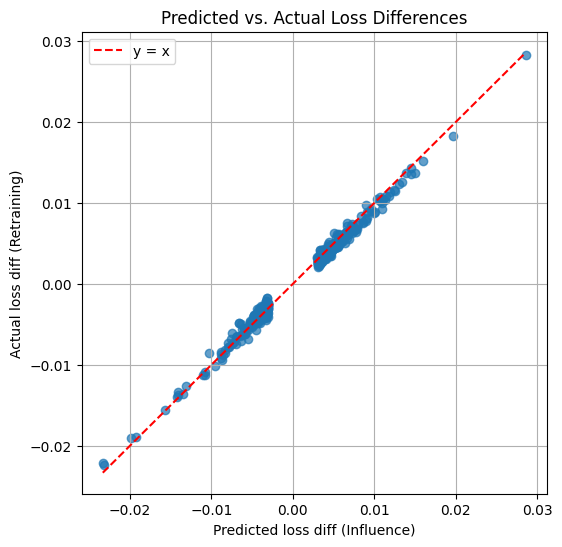

Spearman correlation: 0.9797 (p = 0)
Pearson correlation: 0.9964 (p = 0)


In [14]:


# Plot and analyze results
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

plt.figure(figsize=(6, 6))
plt.scatter(predicted_loss_diffs[top_indices], actual_loss_diffs, alpha=0.7)

# y=x line
min_val = min(predicted_loss_diffs[top_indices].min(), actual_loss_diffs.min())
max_val = max(predicted_loss_diffs[top_indices].max(), actual_loss_diffs.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")

plt.xlabel("Predicted loss diff (Influence)")
plt.ylabel("Actual loss diff (Retraining)")
plt.title("Predicted vs. Actual Loss Differences")
plt.legend() 
plt.grid(True) 
plt.show()

# Correlation analysis
rho, pval = spearmanr(predicted_loss_diffs[top_indices], actual_loss_diffs)
print(f"Spearman correlation: {rho:.4f} (p = {pval:.4g})")

# Also compute Pearson correlation
from scipy.stats import pearsonr
r, p = pearsonr(predicted_loss_diffs[top_indices], actual_loss_diffs)
print(f"Pearson correlation: {r:.4f} (p = {p:.4g})")